# AirBnB Seattle / Boston Data Analysis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from collections import Counter
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split 
from sklearn.metrics import r2_score, mean_squared_error
% matplotlib inline

In [ ]:
Data gathering
Data assessment
Data cleaning
Data analyze
Model
Visualization

## Data Gathering

Data was gathered from Kaggle [here](https://www.kaggle.com/airbnb/boston) and [here](https://www.kaggle.com/airbnb/seattle). The files are saved into the current directory under ./data/seattle/ and ./data/boston/ subdirectories respectively for Seattle and Boston data.

## Data Assessment and Data Cleaning

Next, I'll load in each dataset and assess the values and clean them as necessary.

In [2]:
sea_cal = pd.read_csv("./data/seattle/calendar.csv", dtype=str)
sea_listings = pd.read_csv("./data/seattle/listings.csv", dtype=str)
sea_reviews = pd.read_csv("./data/seattle/reviews.csv", dtype=str)

I'm going to start by taking a look at the `sea_cal` DataFrame. Note that I've set the `dtype` parameter for the `read_csv` function to `str`. The reason for doing this is that I want to manually specify the types of each variable being read in, to ensure data integrity, especially since this is a foreign dataset to me. One common thing that can happen is leading zeros being trimmed for ID numbers because they get interpreted as a numeric value, and I'll be going through the data anyway, so might as well stay safe.

First, I'll just examine each dataset, and then perform type conversions and data cleaning as necessary.

In [3]:
display(sea_cal.head())
print(sea_cal.isna().sum(axis=0))

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


listing_id         0
date               0
available          0
price         459028
dtype: int64


In [4]:
# Convert date to timestamp, available to 0/1 boolean
sea_cal["date"] = sea_cal["date"].map(lambda x: pd.Timestamp(x))
sea_cal["available"] = sea_cal["available"].map(lambda x: 1 if x=="t" else 0)

# Remove comma and $ sign from price strings, then convert to float
sea_cal.loc[~sea_cal["price"].isna(), "price"] = \
  sea_cal.loc[~sea_cal["price"].isna(), "price"].map(lambda x: x.replace("$", "").replace(",", ""))
sea_cal["price"] = sea_cal["price"].astype("float64")

Next, I'll do the same for the `sea_reviews` data.

In [5]:
display(sea_reviews.head())
print(sea_reviews.isna().sum(axis=0))

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


listing_id        0
id                0
date              0
reviewer_id       0
reviewer_name     0
comments         18
dtype: int64


In [6]:
sea_reviews["date"] = sea_reviews["date"].map(lambda x: pd.Timestamp(x))

Everything else for the reviews data can stay as is, it's either identifier data or text, which both should stay as strings. Note here that the `listing_id` connects the reviews data to both the calendar data and the listings data. The `id` column here is a unique identifier for reviews, so it can potentially be dropped for the purposes of analysis. the `reviewer_id` can be used to aggregate data by reviewers, so we'll keep that, and the text columns are self-explanatory. Onto the last dataset!

In [7]:
sea_listings.shape

(3818, 92)

There's 92 columns here, which is a lot. However, I personally am interested in knowing what all the columns are before I come up with the questions I'm interested in answering, so I'll go through them all and keep them as necessary. Below are the results after maybe an hour or so of manually examining the data in the dataset; I've separated the data by a few types that I'll have to clean appropriately: 
  * Numeric
  * Non-numeric (including both categorical and string)
  * Array (variables that contain multiple items that may need to be handled with some extra effort)
  * Boolean (T/F variables) 
  * Timestamp
  * Variables to drop (These may have little variation, many missing values, and some, like listing URLs, aren't relevant to the analysis I want to do.)

#### Missing Data Handling #1

Note here I've decided to drop variables that have almost all missing values (>90%) from my listings dataset. There's so much data missing in these variables that it's not useful for modeling purposes at all. Alternatives here include imputation of missing data, but imputation of data is a bad idea if you're imputing 90% of missing data off of 10% of true data. Later, in the modeling process, I'll do some more missing data handling for the remainder of the missing data.

In [8]:
num_vars = [23,           # Host Reponse Rate \
            24,           # Host Acceptance Rate \
            29,           # Host Listings Count \
            30,           # Host Total Listings Count \
            50,           # Accomodates (I'm guessing number of people) \
            51,           # Bathrooms \
            52,           # Bedrooms \
            53,           # Beds \
            57,           # Price \
            58,           # Weekly Price \
            59,           # Monthly Price \
            60,           # Security Deposit \
            61,           # Cleaning Fee \
            62,           # Guests Included \
            63,           # Extra People (Cost Per) \
            64,           # Minimum Nights \
            65,           # Maximum Nights \
            68,           # Availability 30 \
            69,           # Availability 60 \
            70,           # Availability 90 \
            71,           # Availability 365 \
            73,           # Number of reviews \
            76,           # Review scores rating \
            77,           # Review scores accuracy \
            78,           # Review scores cleanliness \
            79,           # Review scores check-in \
            80,           # Review scores communication \
            81,           # Review scores location \
            82,           # Review scores value \
            90,           # Calculated host listings count \
            91]           # Reviews per month \

non_num_vars = [0,        # Listing ID \
                4,        # Listing Name \
                5,        # Listing Summary     (Mostly short ver. of 7) \
                6,        # Space Description \
                7,        # Listing Description (Mostly long ver. of 5) \
                9,        # Neighborhood Overview \
                10,       # Notes \
                11,       # Transit \
                16,       # Host ID \
                18,       # Host Name \
                20,       # Host Location \
                21,       # About Host \
                22,       # Host Response Time \
                28,       # Host Neighborhood \
                34,       # Listing street \
                35,       # Listing neighborhood \
                36,       # Listing neighborhood cleansed \
                37,       # Listing neighborhood group cleansed \
                40,       # Zip code \
                48,       # Property type \
                49,       # Room type \
                54,       # Bed type \
                66,       # Calendar last updated \
                87]       # Cancellation policy (flexible, strict, moderate) \

array_vars = [31,         # Host verifications \
              55]         # Amenities \
                
boolean_vars = [25,       # Host is superhost \
                32,       # Host has profile pic \
                33,       # Host has identity verified \
                47,       # Is location exact \
                86,       # Instant bookable \
                88,       # Requires guest profile picture \
                89]       # Requires guest phone verif. \

timestamp_vars = [3,      # Last scraped date \
                  19,     # Host since (date) \
                  74,     # First review (date) \
                  75]     # Last review (date) \

vars_to_drop = [1,        # Listing URL \
                2,        # Scrape ID \
                8,        # Experiences offered (No meaningful data) \
                12,       # Thumbnail URL \
                13,       # Medium URL \
                14,       # Picture URL \
                15,       # XL Picture URL \
                17,       # Host URL \
                26,       # Host Thumbnail URL \
                27,       # Host Picture URL \
                38,       # City (basically all Seattle) \
                39,       # State (basically all WA) \
                41,       # Market (all Seattle) \
                42,       # Smart location (basically all Seattle) \
                43,       # Country code (all US) \
                44,       # Country (all US) \
                45,       # Latitude \
                46,       # Longitude \
                56,       # Square feet (97.5% missing data) \
                67,       # Has availability \ (No variation)
                72,       # Calendar last scraped (All same date) \
                83,       # Requires license (No variation) \
                84,       # License (Missing all data) \
                85]       # Juridisction names (All WA)

In [9]:
len(set(num_vars + non_num_vars + boolean_vars + array_vars + timestamp_vars + vars_to_drop))

92

Because some of these variables will be handled in a similar fashion, I've written a function to help me clean the timestamp, boolean, and numeric variables. The function works by subsetting the appropriate columns, then iterating over each column with a "cleaning function" defined for the type of variable.

In [10]:
def clean_columns_map(index_arr, map_fn):   
    """
    This function takes in an index array and map function and applies the
    map function to the indexed columns.
    
    @param index_arr: array of integer indices to apply map function to 
    @param map_fn: map function specifying transformation of each value
    @output df: transformed column
    """
    df = sea_listings.iloc[:, index_arr]
    for col in df:
        df.loc[:, col] = df.loc[:, col].map(map_fn)
    return df

In [11]:
timestamp_vars_df = clean_columns_map(timestamp_vars, lambda x: pd.Timestamp(x))
boolean_vars_df = clean_columns_map(boolean_vars, lambda x: x if x is np.nan else int(x == "t"))

num_translation_table = dict.fromkeys(map(ord, "$%,"))
num_vars_df = clean_columns_map(num_vars, \
    lambda x: x if x is np.nan else np.float64(x.translate(num_translation_table)))

/Users/brianwang/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:630: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/Users/brianwang/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


The array variables I've handled below a bit more manually. Unlike regular categorical variables, these fields can take on multiple values at one time; for example, a listing can have multiple amenities, or a host can be verified multiple ways. I don't want to handle these columns with the regular `get_dummies` function. For example, applying `get_dummies` to a column with the strings \[phone\], \[email\], and \[phone, email\] would produce 3 dummy columns, but I only want two columns that represent if 'phone' is present or if 'email' is present. Thus, I've manually gone through and created the appropriate columns by following 3 steps.

1. Parse each string into a list of values.
2. Set union all the lists to obtain one set of unique values.
3. For each value in the set, check for membership in each string and produce a column from the results.

In [12]:
array_vars_df = sea_listings.iloc[:, array_vars]

In [13]:
# Parse and handle host verifications array
uniq_vals = set()
translation_table = dict.fromkeys(map(ord, "['',]"))
for r in array_vars_df["host_verifications"]:
    uniq_vals = uniq_vals.union(set(r.translate(translation_table).split(" ")))

uniq_vals.remove('')
uniq_vals.remove('None')

array_cleaned_df = pd.DataFrame()
for val in uniq_vals:
    col_name = 'host_verification_' + val
    val_col = pd.DataFrame({ col_name : array_vars_df["host_verifications"].map(lambda x: 1 if val in x else 0)})
    array_cleaned_df = pd.concat([array_cleaned_df, val_col], axis=1)

# Parse and handle amenities array
uniq_vals = set()
translation_table = dict.fromkeys(map(ord, "{['']}\""))
for r in array_vars_df["amenities"]:
    uniq_vals = uniq_vals.union(set(r.translate(translation_table).split(",")))

uniq_vals.remove('')
for val in uniq_vals:
    col_name = 'amenities_' + val
    val_col = pd.DataFrame({ col_name : array_vars_df["amenities"].map(lambda x: 1 if val in x else 0)})
    array_cleaned_df = pd.concat([array_cleaned_df, val_col], axis=1)

Lastly, I need to handle the non-numeric variables. The thing is, not all the non-numeric variables here are categorical variables; in fact, most of them are strings of some sort. I'm going to attempt to separate the true categorical variables out by looking at the number of unique values each column takes. I'm going to use a pretty strict threshold of 10 unique values for now, because I don't want `get_dummies` to give me an unreasonable number of dummy columns.

In [14]:
non_num_vars_df = sea_listings.iloc[:, non_num_vars]

In [15]:
cat_vars = []
str_vars = []
for col in non_num_vars_df.columns:
    uniq_vals = non_num_vars_df[col].value_counts().shape[0]
    if uniq_vals < 10:
        cat_vars.append(col)
    else:
        str_vars.append(col)

#### Categorical Variable Handling

Here, to handle the categorical variables I will use the pandas function `get_dummies`, which will one-hot encode each categorical variable. I've set the parameters `drop_first=True` and `dummy_na=False`, which will drop the first level of categorical variables and not create an additional dummy NA column.

In [16]:
# Get dummy columns for the categorical variables
cat_vars_df = non_num_vars_df.loc[:, cat_vars]
cat_vars_df = pd.get_dummies(cat_vars_df, drop_first=True, dummy_na=False)

Lastly, I'll concatenate all the cleaned columns together.

In [17]:
cleaned_df = pd.concat([boolean_vars_df, num_vars_df, array_cleaned_df, cat_vars_df], axis=1)

* Calendar data:
    * How does availability and price change over the course of the year (more specifically, with respect to date)?
    
* Reviews data:
    * How do the number of reviews change over the year? 
    * What's the most common reviewer names?
    * What are the most common adjectives in reviews?
  
* Listings data:
    * What are some of the features most correlated with price?

Since I also have the Boston dataset, and I'm expecting the schema of the Boston dataset to be relatively similar, I'm just going to load in that data as well and run through all the preceding cleaning steps in a single cell below. That way, when I proceed with answering the above questions for Seattle, I can also compare and contrast the answers with Boston data as well. Note that if I were to continuing processing data in this fashion, I should probably write a re-usable function, but since it's just this one additional time, I can just change all the variable names.

In [18]:
bos_cal = pd.read_csv("./data/boston-airbnb-open-data/calendar.csv", dtype=str)
bos_listings = pd.read_csv("./data/boston-airbnb-open-data/listings.csv", dtype=str)
bos_reviews = pd.read_csv("./data/boston-airbnb-open-data/reviews.csv", dtype=str)

# Convert date to timestamp, available to 0/1 boolean
bos_cal["date"] = bos_cal["date"].map(lambda x: pd.Timestamp(x))
bos_cal["available"] = bos_cal["available"].map(lambda x: 1 if x=="t" else 0)

# Remove comma and $ sign from price strings, then convert to float
bos_cal.loc[~bos_cal["price"].isna(), "price"] = \
  bos_cal.loc[~bos_cal["price"].isna(), "price"].map(lambda x: x.replace("$", "").replace(",", ""))
bos_cal["price"] = bos_cal["price"].astype("float64")

bos_reviews["date"] = bos_reviews["date"].map(lambda x: pd.Timestamp(x))

# The boston listing dataset has some extra columns, which I will drop
bos_listings = bos_listings.drop(columns=bos_listings.columns[~bos_listings.columns.isin(sea_listings.columns)])

# Redefine function to use BOS
def clean_columns_map(index_arr, map_fn):
    """
    This function takes in an index array and map function and applies the
    map function to the indexed columns.
    
    @param index_arr: array of integer indices to apply map function to 
    @param map_fn: map function specifying transformation of each value
    @output df: transformed column
    """
    df = bos_listings.iloc[:, index_arr]
    for col in df:
        df.loc[:, col] = df.loc[:, col].map(map_fn)
    return df

timestamp_vars_df = clean_columns_map(timestamp_vars, lambda x: pd.Timestamp(x))
boolean_vars_df = clean_columns_map(boolean_vars, lambda x: x if x is np.nan else int(x == "t"))

num_translation_table = dict.fromkeys(map(ord, "$%,"))
num_vars_df = clean_columns_map(num_vars, \
    lambda x: x if x is np.nan else np.float64(x.translate(num_translation_table)))

array_vars_df = bos_listings.iloc[:, array_vars]

# Parse and handle host verifications array
uniq_vals = set()
translation_table = dict.fromkeys(map(ord, "['',]"))
for r in array_vars_df["host_verifications"]:
    uniq_vals = uniq_vals.union(set(r.translate(translation_table).split(" ")))

uniq_vals.remove('')
# uniq_vals.remove('None')

array_cleaned_df = pd.DataFrame()
for val in uniq_vals:
    col_name = 'host_verification_' + val
    val_col = pd.DataFrame({ col_name : array_vars_df["host_verifications"].map(lambda x: 1 if val in x else 0)})
    array_cleaned_df = pd.concat([array_cleaned_df, val_col], axis=1)

# Parse and handle amenities array
uniq_vals = set()
translation_table = dict.fromkeys(map(ord, "{['']}\""))
for r in array_vars_df["amenities"]:
    uniq_vals = uniq_vals.union(set(r.translate(translation_table).split(",")))

uniq_vals.remove('')
for val in uniq_vals:
    col_name = 'amenities_' + val
    val_col = pd.DataFrame({ col_name : array_vars_df["amenities"].map(lambda x: 1 if val in x else 0)})
    array_cleaned_df = pd.concat([array_cleaned_df, val_col], axis=1)
    
non_num_vars_df = bos_listings.iloc[:, non_num_vars]

cat_vars = []
str_vars = []
for col in non_num_vars_df.columns:
    uniq_vals = non_num_vars_df[col].value_counts().shape[0]
    if uniq_vals < 10:
        cat_vars.append(col)
    else:
        str_vars.append(col)
        
# Get dummy columns for the categorical variables
cat_vars_df = non_num_vars_df.loc[:, cat_vars]
cat_vars_df = pd.get_dummies(cat_vars_df, drop_first=True, dummy_na=False)

cleaned_bos_df = pd.concat([boolean_vars_df, num_vars_df, array_cleaned_df, cat_vars_df], axis=1)

/Users/brianwang/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:630: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/Users/brianwang/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


## Data Analysis, Modeling and Visualization

### 1. How does availability and price change over the course of the year?

The first question I want to answer is how does price and availability change over the course of the year. We'll plot this separately for both Boston and Seattle.

Text(0.5,1,'Boston availability (%) by date')

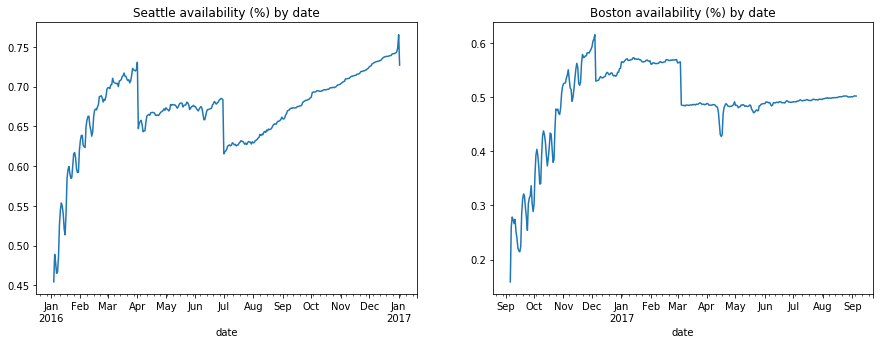

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sea_cal.groupby("date")["available"].mean().plot(ax=ax[0])
ax[0].set_title("Seattle availability (%) by date")
bos_cal.groupby("date")["available"].mean().plot(ax=ax[1])
ax[1].set_title("Boston availability (%) by date")

For Seattle, availability climbs steadily from Jan - April, then has a sudden dip, then climbs again from April to July, drops again, and then finally climbs until the end of the year. For Boston, availability climbs from September to Dec, dips, climbs slightly from Dec to March, dips again, then is relatively stable from March to September. It's interesting that there are similarities in the two datasets despite them being tracked on different date ranges.

Text(0.5,1,'Average Boston price ($) by date')

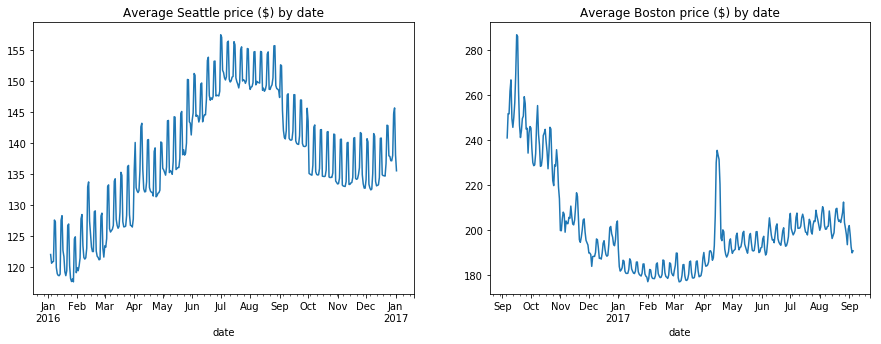

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sea_cal.groupby("date")["price"].mean().plot(ax=ax[0])
ax[0].set_title("Average Seattle price ($) by date")
bos_cal.groupby("date")["price"].mean().plot(ax=ax[1])
ax[1].set_title("Average Boston price ($) by date")

Creating the same plots for price, we see that there is a cyclical weekly pattern, as well as seasonal trends. For Seattle, price trends upward from January, peaking in the summer, and then dropping gradually until the end of the year. For Boston, however, prices climb steadily from January to September; there's an interesting price spike around mid-April, possibly spring break or something? This spike also corresponds with a dip in Boston availability.

### 2. How do the number of reviews changes over the year? What are the most popular names of reviewers? What are the most common words used in reviews?

To visualize how the number of reviews changes over the year, I'm going to actually aggregate by month. It shouldn't necessarily change the shape of the graph, but it should smooth out the presentation a bit because we're dealing with multiple years of data.

In [21]:
sea_reviews["year_month"] = sea_reviews["date"].map(lambda x: pd.Timestamp(x.year, x.month, 1, 0))
bos_reviews["year_month"] = bos_reviews["date"].map(lambda x: pd.Timestamp(x.year, x.month, 1, 0))

Text(0.5,1,'Number of reviews by month, Boston')

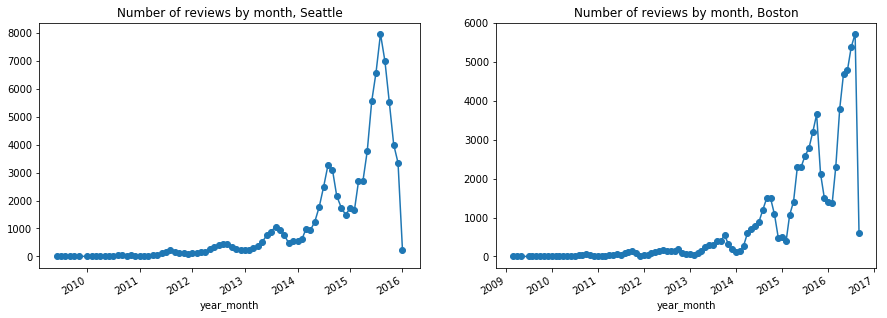

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sea_reviews.groupby("year_month")["reviewer_id"].count().plot(ax=ax[0], marker='o')
ax[0].set_title("Number of reviews by month, Seattle")
bos_reviews.groupby("year_month")["reviewer_id"].count().plot(ax=ax[1], marker='o')
ax[1].set_title("Number of reviews by month, Boston")

It seems that in general, people tend to write the most reviews in the summer; there's a clear cyclical pattern evident in the plot. Next, let's check out what the most common reviewer names are.

Text(0.5,1,'Most popular reviewer names, Boston')

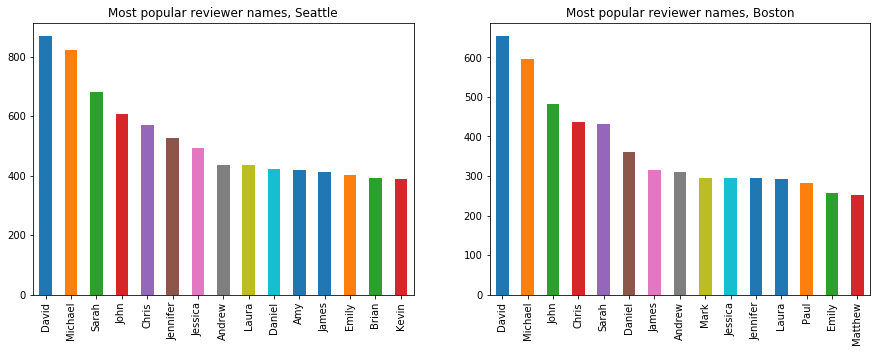

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sea_reviews["reviewer_name"].value_counts().sort_values(ascending=False)[0:15].plot(kind="bar", ax=ax[0])
ax[0].set_title("Most popular reviewer names, Seattle")
bos_reviews["reviewer_name"].value_counts().sort_values(ascending=False)[0:15].plot(kind="bar", ax=ax[1])
ax[1].set_title("Most popular reviewer names, Boston")

David is the most common male reviewer name; Sarah is the most common female reviewer name. My own name, Brian, is 14th! Yeah, my name's pretty common. For Boston, the names are pretty similar, though ordered a bit differently. The ranking of my name falls into the 20s here :(. Lastly, we're going to have a bit of fun seeing what the most common words in reviews are.

In [24]:
stop_words = ["and", "the", "to", "a", "was", "in", "we", "is", "of", "i", "for", "with", "it", "our", "were", "had", "us", "you", '',
             "this", "as", "my", "as", "at", "so", "would", "that", "on", "there", "but", "she", "are", "they", "me", "an", "her", "have",
             "very", "he", "if", "all", "be", "from", "him"]

comments_master_str = ""
for val in sea_reviews["comments"]:
    comments_master_str += " " + str(val).lower()

# Remove all non-letter/space characters
# Found this trick here: https://stackoverflow.com/questions/21564625/removing-everything-except-letters-and-spaces-from-string-in-python3-3
whitelist = set('abcdefghijklmnopqrstuvwxyz ABCDEFGHIJKLMNOPQRSTUVWXYZ')
comments_master_str = ''.join(filter(whitelist.__contains__, comments_master_str))
comments_master_str = comments_master_str.replace("  ", "")

c = Counter(comments_master_str.split(" "))
for val in stop_words:
    del c[val]
c.most_common(25)

[('great', 56276),
 ('stay', 48638),
 ('place', 43408),
 ('seattle', 34258),
 ('clean', 27237),
 ('location', 26280),
 ('apartment', 24432),
 ('comfortable', 22423),
 ('nice', 21772),
 ('house', 21455),
 ('room', 19704),
 ('home', 18190),
 ('host', 18133),
 ('everything', 18035),
 ('again', 16969),
 ('time', 16860),
 ('easy', 16711),
 ('neighborhood', 16525),
 ('really', 15958),
 ('recommend', 15818),
 ('definitely', 15010),
 ('perfect', 14815),
 ('downtown', 14421),
 ('not', 14386),
 ('well', 14071)]

Some of the most common adjectives used in reviews are clean, comfortable, great and nice. It seems that many reviewers comment on location and comfort, with other location-related nouns like neighborhood and downtown also being common. The results aren't much different for Boston:

In [25]:
# Count words in Boston reviews
comments_master_str = ""
for val in bos_reviews["comments"]:
    comments_master_str += " " + str(val).lower()

# Remove all non-letter/space characters
# Found this trick here: https://stackoverflow.com/questions/21564625/removing-everything-except-letters-and-spaces-from-string-in-python3-3
comments_master_str = ''.join(filter(whitelist.__contains__, comments_master_str))
comments_master_str = comments_master_str.replace("  ", "")

c_bos = Counter(comments_master_str.split(" "))
for val in stop_words:
    del c_bos[val]
c_bos.most_common(25)

[('great', 37034),
 ('stay', 33164),
 ('place', 28827),
 ('boston', 27795),
 ('apartment', 26798),
 ('clean', 21559),
 ('location', 20941),
 ('room', 19141),
 ('nice', 17826),
 ('host', 15832),
 ('comfortable', 14280),
 ('house', 13666),
 ('not', 13260),
 ('everything', 12674),
 ('really', 12323),
 ('easy', 12044),
 ('recommend', 11838),
 ('time', 11634),
 ('good', 10878),
 ('again', 10658),
 ('well', 10171),
 ('home', 10109),
 ('perfect', 9836),
 ('definitely', 9766),
 ('also', 9765)]

That wasn't nearly interesting as I hoped it would be - I guess in humans in Seattle and Boston are more similar than I thought. I'm going to try a different approach, though - I'm going to take the top 500 words in Seattle reviews, and then see how much more common they appear in Boston reviews by evaluating the ratio between Boston count and Seattle count. To be fair, this analysis will miss words that completely don't show up in Seattle reviews, but my goal is more along the lines of, among words that are common between reviewers, which ones are much more commonly used in Boston? -  so this works. We see that words like "station", "airport", show up much more commonly in Boston reviews, suggesting that the train and access to the airport may be important to reviewers in Boston.

In [26]:
c_ratio = Counter()
for val in c.most_common(500):
    c_ratio[val[0]] = c_bos[val[0]] / c[val[0]]
c_ratio.most_common(10)

[('station', 3.859375),
 ('airport', 1.9832797427652733),
 ('floor', 1.2304199772985245),
 ('fine', 1.1830624465355004),
 ('old', 1.1818181818181819),
 ('rooms', 1.17359413202934),
 ('public', 1.1210310048561822),
 ('however', 1.1084033613445379),
 ('apartment', 1.096840209561231),
 ('air', 1.0857971014492753)]

Repeating the analysis for Seattle instead, we see that common words are 'view', 'hill', 'downtown', 'bus', and 'bars'. Surprisingly, 'fun' shows up 2.6 times more often in Seattle reviews. Seems people may think that Seattle is more fun than Boston!

In [27]:
c_ratio = Counter()
for val in c_bos.most_common(500):
    c_ratio[val[0]] = c[val[0]] / c_bos[val[0]]
c_ratio.most_common(10)

[('view', 4.027916964924839),
 ('hill', 3.3654507914659324),
 ('downtown', 3.1288782816229115),
 ('bus', 3.083639330885353),
 ('light', 2.9448217317487266),
 ('bars', 2.8625756266205706),
 ('fun', 2.7639810426540286),
 ('space', 2.622895622895623),
 ('coffee', 2.6192242833052277),
 ('stocked', 2.567769477054429)]

### 3. What are the features correlated with listing price using the listings dataset?

Finally, I'm going to run a simple linear regression to predict price using the set of cleaned variables I have.

#### Missing Data Handling #2

I've chosen to drop additional missing data before I run my regression. I'll decide to drop row or column depending on the number of missing values in the column. Other options here include data imputation or creating columns to represent missing/not missing data. However, I've chosen simply to drop data because I don't want to impute pretend data that may bias the model.

In [28]:
cols_with_na = cleaned_df.isna().sum(axis=0)
print(cols_with_na[cols_with_na > 0])
cols_to_drop = cols_with_na[cols_with_na > 20].index

host_is_superhost                 2
host_has_profile_pic              2
host_identity_verified            2
host_response_rate              523
host_acceptance_rate            773
host_listings_count               2
host_total_listings_count         2
bathrooms                        16
bedrooms                          6
beds                              1
weekly_price                   1809
monthly_price                  2301
security_deposit               1952
cleaning_fee                   1030
review_scores_rating            647
review_scores_accuracy          658
review_scores_cleanliness       653
review_scores_checkin           658
review_scores_communication     651
review_scores_location          655
review_scores_value             656
reviews_per_month               627
dtype: int64


Here, I can see that there are columns that are missing hundreds of values and then a set of columns that are only missing a few. I'll drop the columns that are missing large numbers of values and then drop the remaining observations that are just missing a few. This way, I've handled all the missing data while dropping as little data as possible. In the cell below, I've also dropped a few additional columns that have low variance, which result in instable coefficient estimates in the regression.

In [29]:
cleaned_df_dropna = cleaned_df.drop(columns = cols_to_drop)
cleaned_df_dropna = cleaned_df_dropna.dropna(axis=0)
cleaned_df_dropna = cleaned_df_dropna.drop(columns=["amenities_Washer / Dryer"]) # No variance
cleaned_df_dropna = cleaned_df_dropna.drop(columns=["host_verification_photographer"]) # Numerical instability

In [30]:
y = cleaned_df_dropna[["price"]]
X = cleaned_df_dropna.loc[:, ~(cleaned_df_dropna.columns=="price")]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

mod = LinearRegression(normalize=False)
mod.fit(X_train, y_train)

y_train_preds = mod.predict(X_train)
y_test_preds = mod.predict(X_test)

print(r2_score(y_train, y_train_preds))
print(r2_score(y_test, y_test_preds))
print(mean_squared_error(y_train, y_train_preds))
print(mean_squared_error(y_test, y_test_preds))

0.577663387721407
0.5858424925506823
3515.4633819237133
3240.88207618554


In [31]:
coefs_df = pd.DataFrame()
coefs_df['var_name'] = X_train.columns
coefs_df['coefs'] = mod.coef_[0, :]
coefs_df['abs_coefs'] = np.abs(mod.coef_[0, :])

pd.set_option('display.float_format', lambda x: '%.3f' % x)
coefs_df.sort_values('abs_coefs', ascending=False).head(10)

,var_name,coefs,abs_coefs
80,room_type_Shared room,-78.349,78.349
24,host_verification_sent_id,51.963,51.963
1,host_has_profile_pic,-44.365,44.365
79,room_type_Private room,-43.450,43.450
78,host_response_time_within an hour,-33.883,33.883
44,amenities_Wireless Internet,33.082,33.082
57,amenities_Doorman,32.445,32.445
11,bedrooms,32.391,32.391
40,amenities_Internet,-30.899,30.899
10,bathrooms,28.976,28.976


For Seattle, the top positive features associated with price are `host_verification_sent_id`, `amenities_Wireless Internet`, and `amenities_Doorman`, as well as `bedrooms` and `bathrooms` which we might expect. The top negative features include `room_type_Shared room` and `room_type_Private room`. Let's check out what the top features are for Boston.

In [32]:
cols_with_na = cleaned_bos_df.isna().sum(axis=0)
print(cols_with_na[cols_with_na > 0])
cols_to_drop = cols_with_na[cols_with_na > 20].index

cleaned_bos_df_dropna = cleaned_bos_df.drop(columns = cols_to_drop)
cleaned_bos_df_dropna = cleaned_bos_df_dropna.dropna(axis=0)
cleaned_bos_df_dropna = cleaned_bos_df_dropna.drop(columns=["host_listings_count"]) # Collinear with another column

host_response_rate              471
host_acceptance_rate            471
bathrooms                        14
bedrooms                         10
beds                              9
weekly_price                   2693
monthly_price                  2697
security_deposit               2243
cleaning_fee                   1107
review_scores_rating            813
review_scores_accuracy          823
review_scores_cleanliness       818
review_scores_checkin           820
review_scores_communication     818
review_scores_location          822
review_scores_value             821
reviews_per_month               756
dtype: int64


In [33]:
y = cleaned_bos_df_dropna[["price"]]
X = cleaned_bos_df_dropna.loc[:, ~(cleaned_bos_df_dropna.columns=="price")]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

mod = LinearRegression(normalize=True)
mod.fit(X_train, y_train)

y_train_preds = mod.predict(X_train)
y_test_preds = mod.predict(X_test)

print(r2_score(y_train, y_train_preds))
print(r2_score(y_test, y_test_preds))
print(mean_squared_error(y_train, y_train_preds))
print(mean_squared_error(y_test, y_test_preds))

0.5212002051873474
-0.6098530203538219
6953.498330865948
63968.78338672878


In [34]:
coefs_df = pd.DataFrame()
coefs_df['var_name'] = X_train.columns
coefs_df['coefs'] = mod.coef_[0, :]
coefs_df['abs_coefs'] = np.abs(mod.coef_[0, :])

pd.set_option('display.float_format', lambda x: '%.3f' % x)
coefs_df.sort_values('abs_coefs', ascending=False).head(10)

,var_name,coefs,abs_coefs
91,cancellation_policy_super_strict_30,127.564,127.564
25,host_verification_sent_id,-91.221,91.221
83,room_type_Private room,-75.233,75.233
42,amenities_Paid Parking Off Premises,-60.699,60.699
84,room_type_Shared room,-60.280,60.280
23,host_verification_phone,49.885,49.885
60,amenities_Doorman,39.835,39.835
39,amenities_Internet,-37.456,37.456
54,amenities_Free Parking on Premises,-36.382,36.382
10,bedrooms,32.829,32.829


For Boston, the top positive features associated with price are `cancellation_policy_super_strict_30`, `host_verification_phone` and and `amenities_Doorman`, as well as `bedrooms`. The top negative features include `host_verification_sent_id` and `room_type_Private room`.